# Adaptação de domínio para diagnóstico de falhas

Este jupyter é um exemplo de treinamento de um modelo com adaptação de domínio para um diagnóstico de falhas. A técnica utilizada é a redução por Margin Disparity Discrepancy (MDD), proposta por Zhang et al. (2019).

## Importação de bibliotecas

In [ ]:
!pip install tensorflow

In [ ]:
!pip install adapt

In [ ]:
import tensorflow as tf
import numpy as np
import os
import matplotlib.pyplot as plt
from PIL import Image
from adapt.parameter_based import FineTuning
import adapt

In [ ]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import preprocess_input, ResNet50
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input
from sklearn.preprocessing import OneHotEncoder

In [ ]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.constraints import MaxNorm

In [ ]:
from tensorflow.keras.optimizers.schedules import LearningRateSchedule
from tensorflow.keras.optimizers import SGD

In [ ]:
from adapt.feature_based import MDD
from adapt.utils import UpdateLambda

In [ ]:
from google.colab import drive # Utilize esta célula caso esteja em um ambiente do Google Colab
drive.mount('/content/drive')

Mounted at /content/drive


## Funções utilizadas

In [ ]:
def get_Xy(domain, diretorio= diretorio_raiz):



    diretorio_dominio = diretorio + '/' + dominio  + '/images/'
    X = []
    y = []

    for r, d, f in os.walk(path):
        for direct in d:
            if not ".ipynb_checkpoints" in direct:
                for r, d, f in os.walk(os.path.join(path , direct)):
                    for file in f:
                        path_to_image = os.path.join(r, file)
                        if not ".ipynb_checkpoints" in path_to_image:
                            image = Image.open(path_to_image)
                            image = image.resize((224, 224), Image.ANTIALIAS)
                            image = np.array(image, dtype=int)
                            X.append(image)
                            y.append(direct)
    return X, y


In [ ]:
def load_resnet50(path="resnet50_feat.hdf5"):
    model = load_model(path)
    for i in range(len(model.layers)):
        if model.layers[i].__class__.__name__ == "BatchNormalization":
            model.layers[i].trainable = False
    return model

In [ ]:
def get_task(dropout=0.5, max_norm=0.5):

    model = Sequential()
  
    model.add(Dense(1024, activation="relu",
                   kernel_constraint=MaxNorm(max_norm),
                   bias_constraint=MaxNorm(max_norm)))
    model.add(Dropout(dropout))
    model.add(Dense(10, activation="softmax",
                   kernel_constraint=MaxNorm(max_norm),
                   bias_constraint=MaxNorm(max_norm)))
    return model

In [ ]:

class MyDecay(LearningRateSchedule):

    def __init__(self, max_steps=1000, mu_0=0.01, alpha=10, beta=0.75):
        self.mu_0 = mu_0
        self.alpha = alpha
        self.beta = beta
        self.max_steps = float(max_steps)

    def __call__(self, step):
        p = step / self.max_steps
        return self.mu_0 / (1+self.alpha * p)**self.beta

## Importação dos dados e Processamento

A técnica é utilizada com imagens do domínio tempo-frequência. Elas devem ser geradas em uma etapa anterior. A figura abaixo demonstra uma sugestão de divisão de diretórios para o armazenamento das imagens.

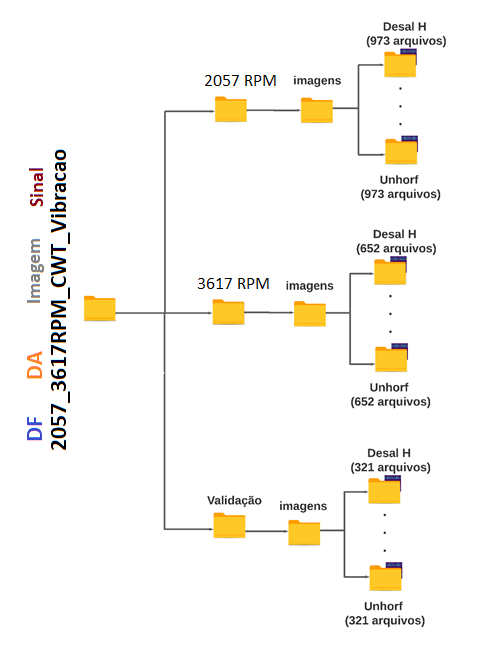

DF corresponde a Domínio Fonte
DA corresponde a Domínio Alvo

No exemplo apresentado, é demonstrado a divisão de dados para treinamento de um modelo que possua dados rotulados no DF a velocidade de 2057 RPM e dados não rotulados no DA a 3617 RPM. Dentro do diretório imagens, há um diretório para armazenar as imagens respectivas a cada classe. A pasta Validacao armazena os dados para serem testados pelo modelo.


In [ ]:
diretorio_raiz = 'cole aqui o caminho do diretório raiz' # No exemplo da figura anterior o diretório raiz é: 2057_3617RPM_CWT_Vibracao


Xs, ys = get_Xy("2057rpm")
Xt, yt = get_Xy("3617rpm")
Xv, yv = get_Xy("Validacao")


# Carregamento da rede Resnet50, remoção da camada de pooling e compilação da rede
resnet50 = ResNet50(weights='imagenet', include_top=False, input_shape=(224,224,3),pooling="avg")
resnet50_feat = Model(resnet50.input, resnet50.output)
resnet50_feat.compile(optimizer='adam', loss='categorical_crossentropy')
resnet50_feat.save("resnet50_feat.hdf5")

# Processamento necessário para adequar as imagens ao shape da Resnet50
Xs = preprocess_input(np.stack(Xs))
Xt = preprocess_input(np.stack(Xt))
Xv = preprocess_input(np.stack(Xv))

# Transformação dos rótulos pelo método OneHot Encoder
one = OneHotEncoder(sparse=False)
one.fit(np.array(ys).reshape(-1, 1))
one = OneHotEncoder(sparse=False)
one.fit(np.array(yv).reshape(-1, 1))

ys_lab = one.transform(np.array(ys).reshape(-1, 1))
yt_lab = one.transform(np.array(yt).reshape(-1, 1))
yv_lab = one.transform(np.array(yv).reshape(-1, 1))


print("X source shape: %s"%str(Xs.shape))
print("X target shape: %s"%str(Xt.shape))
print("X validation shape: %s"%str(Xv.shape))



94765736/94765736 [==============================] - 2s 0us/step
X source shape: (9730, 224, 224, 3)
X target shape: (6520, 224, 224, 3)
X validation shape: (3210, 224, 224, 3)


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [ ]:
lr = 0.004
momentum = 0.9
alpha = 0.0002


optimizer_task = SGD(learning_rate= lr,
                     momentum=momentum, nesterov=True)
optimizer_enc = SGD(learning_rate=lr,
                    momentum=momentum, nesterov=True)

In [ ]:
# Uma vez que as classes são indexadas pelo nome, os dados são embaralhados para garantir que todas as classes sejam 
# representadas durante o treinamento
np.random.seed(0)
shuffle_src = np.random.choice(len(Xs), len(Xs), replace=False)
shuffle_tgt = np.random.choice(len(Xt), len(Xt), replace=False)

Xs = Xs[shuffle_src]
ys_lab = ys_lab[shuffle_src]
Xt = Xt[shuffle_tgt]
yt_lab = yt_lab[shuffle_tgt]

## Treinamento

Conforme mencionado nas etapas anteriores, a técnica utilizada para a adaptação de domínio é a redução do MDD, também utilizada por Zhang et al. (2019). 

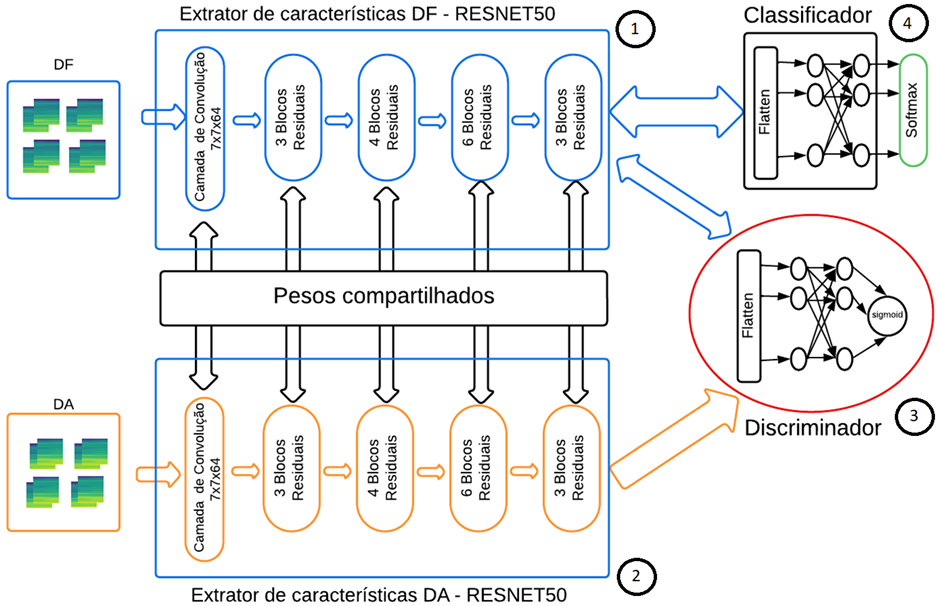

Esta arquitetura é dividida em 4 blocos:

(1)	Extrator de características do DF;

(2)	Extrator de características do DA;

(3)	Discriminador;

(4)	Classificador.

O extrator de características é uma rede convolucional RESNET50.  Todas as camadas da RESNET50 são ativadas para o treinamento. Esta abordagem aumenta o tempo de treinamento mas permite que uma quantidade muito maior de camadas extraiam características mais profundas. Na arquitetura apresentada na figura, o extrator de características do DF compartilha os pesos com o extrator de características do DA. Cada extrator contém 23.587.712 parâmetros treináveis.
Os pesos dos extratores são atualizados pelo discriminador e pelo classificador. O classificador consiste em uma rede neural densa com 1024 neurônios de entrada, sem camadas ocultas, e com 10 neurônios de saída. A função de ativação utilizada é a Softmax. O classificador é alimentado pelas características extraídas do DF. Este domínio possui os rótulos de cada classe, desta forma o erro é propagado para o ajuste dos pesos em ambos os extratores. 
O discriminador é composto por uma rede neural densa com 10 neurônios de entrada, e uma camada oculta com 10 neurônios e um neurônio de saída. Ele é alimentado pelas características extraídas do DF e do DA. O objetivo do discriminador é classificar de qual domínio são advindas as características. 
O treinamento é efetuado de forma que o erro no discriminador aumente e o erro no classificador diminua. Isto faz com que os extratores gerem características representativas, tanto para o DF quanto para o DA, alcançando uma boa acurácia de classificação. As taxas de aprendizado são ajustadas para 0,004 no classificador e 0,0004 no extrator de características

In [ ]:
np.random.seed(123)
tf.random.set_seed(123)


lr = 0.004 
lr_enc = lr/10
momentum = 0.9
alpha = 0.0002
encoder = load_resnet50()
task = get_task()

optimizer_task = SGD(learning_rate=lr,
                     momentum=momentum, nesterov=True)
optimizer_enc = SGD(learning_rate=lr_enc,
                    momentum=momentum, nesterov=True)
optimizer_disc = SGD(learning_rate=lr_enc)


mdd = MDD(encoder, task,
            loss="categorical_crossentropy",
            metrics=["acc"],
            copy=False,
            lambda_=tf.Variable(0.),
            gamma=2.,
            optimizer=optimizer_task,
            optimizer_enc=optimizer_enc,
            optimizer_disc=optimizer_disc,
            callbacks=[UpdateLambda(lambda_max=0.01)])

In [ ]:
mdd.fit(X=Xs[:-1], y=ys_lab[:-1], Xt=Xt, epochs=50, batch_size=10, validation_data=(Xv, yv_lab))

Epoch 1/50
973/973 [==============================] - 113s 98ms/step - loss: 0.9874 - acc: 0.6233 - disc_loss: 3.3573 - val_loss: 1.3806 - val_acc: 0.6106
Epoch 2/50
973/973 [==============================] - 90s 93ms/step - loss: 0.3645 - acc: 0.8622 - disc_loss: 2.0617 - val_loss: 1.2908 - val_acc: 0.5919
Epoch 3/50
973/973 [==============================] - 90s 93ms/step - loss: 0.2444 - acc: 0.9106 - disc_loss: 1.7011 - val_loss: 2.3603 - val_acc: 0.5698
Epoch 4/50
973/973 [==============================] - 90s 93ms/step - loss: 0.1862 - acc: 0.9299 - disc_loss: 1.4738 - val_loss: 2.9217 - val_acc: 0.5442
Epoch 5/50
973/973 [==============================] - 90s 93ms/step - loss: 0.1729 - acc: 0.9394 - disc_loss: 1.3295 - val_loss: 2.1525 - val_acc: 0.5885
Epoch 6/50
973/973 [==============================] - 90s 93ms/step - loss: 0.1426 - acc: 0.9486 - disc_loss: 1.2683 - val_loss: 1.9464 - val_acc: 0.6352
Epoch 7/50
973/973 [==============================] - 90s 92ms/step - loss:

## Evolução da acurácia

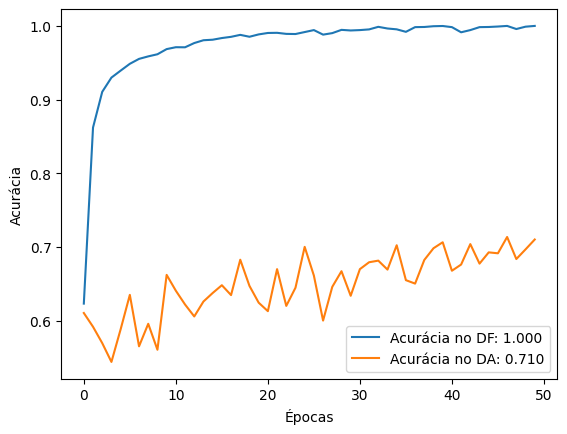

In [ ]:
acc = mdd.history.history["acc"]; val_acc = mdd.history.history["val_acc"]
plt.plot(acc, label="Acurácia no DF: %.3f"%acc[-1])
plt.plot(val_acc, label="Acurácia no DA: %.3f"%val_acc[-1])
plt.legend(); plt.xlabel("Épocas"); plt.ylabel("Acurácia"); plt.show()

## Evolução do erro

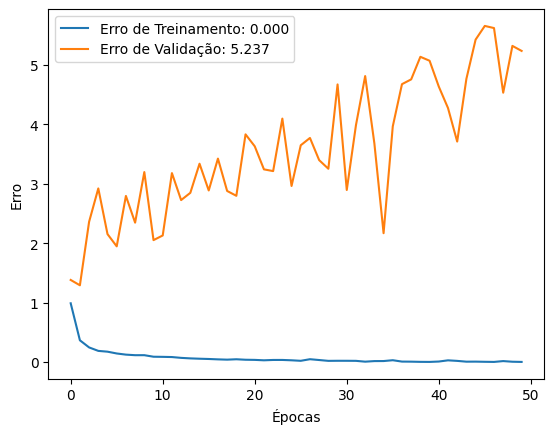

In [ ]:



loss = mdd.history.history["loss"]
val_loss = mdd.history.history["val_loss"]

plt.plot(loss, label="Erro de Treinamento: %.3f" % loss[-1])
plt.plot(val_loss, label="Erro de Validação: %.3f" % val_loss[-1])
plt.legend()
plt.xlabel("Épocas")
plt.ylabel("Erro")
plt.show()


## Evolução do erro no discriminador

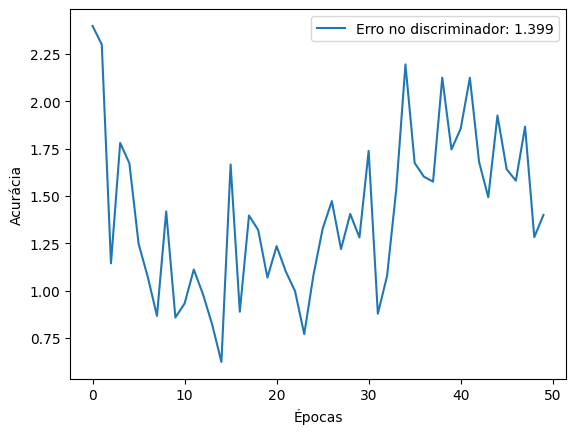

In [ ]:
disc = mdd.history.history["disc_loss"]
plt.plot(disc, label="Erro no discriminador: %.3f"%disc[-1])

plt.legend(); plt.xlabel("Épocas"); plt.ylabel("Acurácia"); plt.show()

## Visualização T-SNE

204/204 [==============================] - 7s 34ms/step


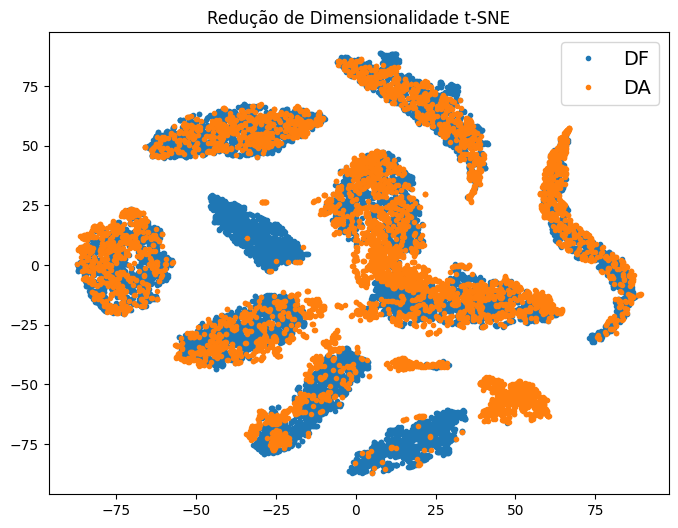

In [ ]:
from sklearn.manifold import TSNE

Xs_enc = mdd.transform(Xs)
Xt_enc = mdd.transform(Xt)

np.random.seed(0)
X_ = np.concatenate((Xs_enc, Xt_enc))
X_tsne = TSNE(2).fit_transform(X_)
plt.figure(figsize=(8, 6))
plt.plot(X_tsne[:len(Xs), 0], X_tsne[:len(Xs), 1], '.', label="DF")
plt.plot(X_tsne[len(Xs):, 0], X_tsne[len(Xs):, 1], '.', label="DA")
plt.legend(fontsize=14)
plt.title("Redução de Dimensionalidade t-SNE")
plt.show()

## Armazenamento do modelo treinado

In [ ]:
tf.saved_model.save(mdd, r'/content/drive/MyDrive/Mestrado Kaique/Resumo de artigos/dados/modelos\Exp58_2057_3617_STFT_rgb_som')